# Simple toy molecule

This toy model illustrates how torsionfit uses Pymc to fit dihedral energy parameters.                                 
The dihedral energy is given as a Fourier series:  

$$E_i^{dih} = \sum_m \sum_{n,j}K_{m,n}(1+cos[n\phi_i])$$

Where m is the torsion type, n is the periodicity, $\phi_i$ is the torsion angle for the $i^{th}$ torsion and $K_{m,n}$ is the force constant for the $m_{th}$ torsion type and periodicity n. Usually, this is fit to a quantum mechanics torsion scan where the energies of the molecule are calculated at different torsion angles around a central bond. 

The toy consists of 4 carbons with bond and angle parameters, no nonbonded parameters and the ability to set dihedral 
parameters to generate a synthetic torsion scan. Pymc is then used to set up the toy model and sample from the posterior. OpenMM, a molecular mechanics toolkit, is used to evaluate the energy in the likelihood. 





In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc import MCMC
import seaborn
import numpy as np
from parmed.topologyobjects import DihedralType
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db

### Set up the toy model
Here we generate configurations around the central bond from -$pi$ to $+pi$ with a step size of $pi/18$. We set the true value to n=3 and $K_3$ = 10.

In [2]:
toy = ToyModel(n_increments=18, sample_phase=False, true_value=DihedralType(20, 3, 0, 1, 1))


13:00:16 INFO torsionFit: initial value for TOY1_offset is 34.42104893505778
13:00:16 INFO torsionFit: initial value for log_sigma_k_CG331_CG321_CG321_CG331 is 0.2001066258197861
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_1_K is 0.0002676415738679269
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_2_K is 2.6379186727120607
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_3_K is -0.1767593310522358
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_4_K is 0.13566865698309324
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_6_K is -1.9889183345342096
13:00:16 INFO torsionFit: initial value for CG331_CG321_CG321_CG331_multiplicity_bitstring is 11


In [3]:
# sample using Pymc MCMC class. 
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='eliminate_rj_randomized.sqlite')
sampler.sample(iter=3000)

 [-----------------100%-----------------] 3000 of 3000 complete in 94.2 sec

## Look at posterior predictive to asses parameter fit
For this model, the posterior predictive is the energy for the different conformations of the molecule. 

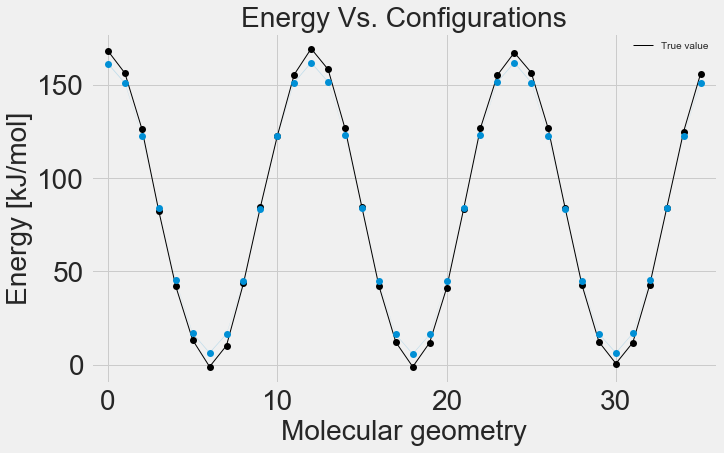

In [4]:
plt.style.use('fivethirtyeight')
scale = 2

default_font = mpl.rcParams['font.size']
fsc = default_font*scale
fig = plt.figure(figsize=(5*scale, 3*scale))
ax = fig.add_subplot(111)

ax.plot(toy.synthetic_energy, color='black', label='True value', linewidth=1)
ax.plot(toy.synthetic_energy, 'ko')
ax.set_xlabel('Molecular geometry', fontsize=fsc)
ax.set_ylabel('Energy [kJ/mol]', fontsize=fsc)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_tick_params(labelsize=fsc)
plt.title('Energy Vs. Configurations', fontsize=fsc)
plt.legend();
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False);

## We can sample over the models to find the model that is most probable given the data!

In [5]:
samples = 3000
multiplicities = (1,2,3,4,6)
mult_bitstring = []
for i in toy.model.pymc_parameters.keys():
    if i.split('_')[-1] == 'bitstring':
        mult_bitstring.append(i)
histogram = np.zeros((1, samples, 5))

for i, j in enumerate(sampler.trace('%s' % mult_bitstring[0])[:]):
    for k, l in enumerate(multiplicities):
        if 2**(l-1) & int(j):
                histogram[0][i][k] = 1

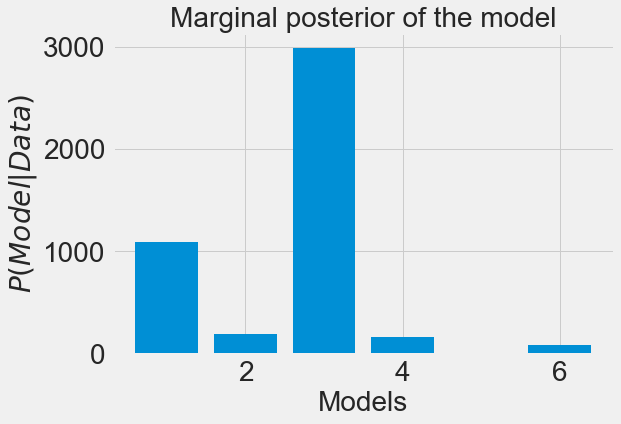

In [6]:
fig, ax = plt.subplots(1,1)
ax.bar(multiplicities, histogram.sum(axis=1)[0]);
ax.set_xlabel('Models', fontsize=fsc)
ax.set_ylabel(r'$P (Model|Data)$', fontsize=fsc)
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_tick_params(labelsize=fsc)
ax.set_title('Marginal posterior of the model', fontsize=fsc);

## Let's look at the marginal posterior of parameters

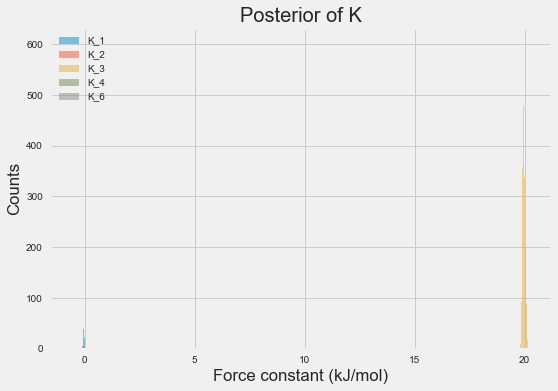

In [7]:
start = 800
t_name = 'CG331_CG321_CG321_CG331'
for i, j in enumerate(multiplicities):
    name = t_name + '_{}_K'.format(j)
    trace = sampler.trace(name)[start:]
    index_0 = np.where(histogram[0, start:, i] == 0)
    index_1 = np.where(histogram[0, start:, i] == 1)
    np.place(trace, histogram[0, start:, i] == 0, np.ones(len(index_0))*np.nan)
    plt.hist(sampler.trace(name)[start:][index_1], alpha=0.5, label='K_{}'.format(j))
plt.legend();
plt.xlabel('Force constant (kJ/mol)')
plt.ylabel('Counts')
plt.title('Posterior of K');